In [1]:
import nltk
import pylab
from nltk import word_tokenize
from nltk.corpus import brown
from tools import show_subtitle
%matplotlib inline

# Ch5 分类和标注词汇

1.  什么是词汇分类，在自然语言处理中它们如何使用？
2.  对于存储词汇和它们的分类来说什么是好的 Python 数据结构？
3.  如何自动标注文本中每个词汇的词类？

-   词性标注（parts-of-speech tagging，POS tagging）：简称标注。将词汇按照它们的词性（parts-of-speech，POS）进行分类并对它们进行标注
-   词性：也称为词类或者词汇范畴。
-   标记集：用于特定任务标记的集合。

### 5.4 自动标注（利用不同的方式给文本自动添加词性标记）

In [2]:
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')
brown_tagged_words = brown.tagged_words(categories='news')
brown_words = brown.words(categories='news')

### 5.4.1 默认标注器

In [3]:
# 寻找在布朗语料库中新闻类文本使用次数最多的标记
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
nltk.FreqDist(tags).max()

'NN'

In [4]:
# 因为 'NN' 是使用次数最多的标记，因此设置它为默认标注
raw = 'I do not lie green eggs and ham, I do not like them Sam I am!'
tokens = nltk.word_tokenize(raw)
default_tagger = nltk.DefaultTagger('NN')
default_tagger.tag(tokens)
default_tagger.evaluate(brown_tagged_sents)  # 评测默认标注的正确率

0.13089484257215028

### 5.4.2 正则表达式标注器

In [5]:
patterns = [
        (r'.*ing$', 'VBG'),  # gerunds
        (r'.*ed$', 'VBD'),  # simple past
        (r'.*es$', 'VBZ'),  # 3rd singular present
        (r'.*ould$', 'MD'),  # modals
        (r'.*\'s$', 'NN$'),  # possessive nouns
        (r'.*s$', 'NNS'),  # plural nouns
        (r'(a|an)', 'AT'),
        (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),  # cardinal numbers
        (r'.*', 'NN')  # nouns (default)
]
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.tag(brown_sents[3])  # 是标注的文本
regexp_tagger.evaluate(brown_tagged_sents)  # brown_tagged_sents 是测试集

0.21873819042504525

### 5.4.3 查询标注器

In [6]:
# 找出 100 个最频繁的词，存储它们最有可能的标记，然后使用这个信息作为“查找标注器”的模型
fd = nltk.FreqDist(brown_words)
cfd = nltk.ConditionalFreqDist(brown_tagged_words)
most_freq_words = fd.most_common(100)
likely_tags = dict(
        (word, cfd[word].max())
        for (word, _) in most_freq_words
)
print("cfd['the']= ", cfd['the'])

cfd['the']=  <FreqDist with 3 samples and 5580 outcomes>


In [7]:
# 一元语法模型，统计词料库中每个单词标注最多的词性作为一元语法模型的建立基础
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
baseline_tagger.evaluate(brown_tagged_sents)

0.45578495136941344

In [8]:
sent = brown_sents[3]
print("sent= ", sent)
baseline_tagger.tag(sent)

sent=  ['``', 'Only', 'a', 'relative', 'handful', 'of', 'such', 'reports', 'was', 'received', "''", ',', 'the', 'jury', 'said', ',', '``', 'considering', 'the', 'widespread', 'interest', 'in', 'the', 'election', ',', 'the', 'number', 'of', 'voters', 'and', 'the', 'size', 'of', 'this', 'city', "''", '.']


[('``', '``'),
 ('Only', None),
 ('a', 'AT'),
 ('relative', None),
 ('handful', None),
 ('of', 'IN'),
 ('such', None),
 ('reports', None),
 ('was', 'BEDZ'),
 ('received', None),
 ("''", "''"),
 (',', ','),
 ('the', 'AT'),
 ('jury', None),
 ('said', 'VBD'),
 (',', ','),
 ('``', '``'),
 ('considering', None),
 ('the', 'AT'),
 ('widespread', None),
 ('interest', None),
 ('in', 'IN'),
 ('the', 'AT'),
 ('election', None),
 (',', ','),
 ('the', 'AT'),
 ('number', None),
 ('of', 'IN'),
 ('voters', None),
 ('and', 'CC'),
 ('the', 'AT'),
 ('size', None),
 ('of', 'IN'),
 ('this', 'DT'),
 ('city', None),
 ("''", "''"),
 ('.', '.')]

In [9]:
# 对于一元语法模型不能标注的单词，使用默认标注器，这个过程叫做“回退”。
baseline_tagger = nltk.UnigramTagger(model=likely_tags, backoff=nltk.DefaultTagger('NN'))
baseline_tagger.evaluate(brown_tagged_sents)

0.5817769556656125

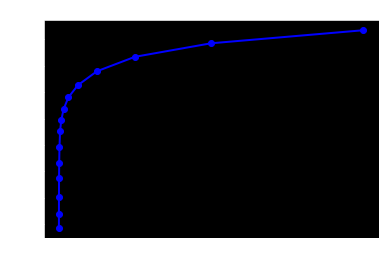

In [10]:
# Ex5-4 查找标注器的性能评估
def performance(cfd, wordlist):
    lt = dict(
            (word, cfd[word].max()) 
            for word in wordlist
    )
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(brown_tagged_sents)


def display():
    word_freqs = nltk.FreqDist(brown_words).most_common()
    words_by_freq = [
            w 
            for (w, _) in word_freqs
    ]
    cfd = nltk.ConditionalFreqDist(brown_tagged_words)
    sizes = 2 ** pylab.arange(15)
    # 单词模型容量的大小对性能的影响
    perfs = [
            performance(cfd, words_by_freq[:size]) 
            for size in sizes
    ]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()


display()